### Import Libraries 

In [1]:
#import libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import random as random
import seaborn as sns
import copy
sns.set()
%matplotlib inline

In [42]:
#Traffic Simulation base class

'''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            length (int) The number of cells in the lane. 
                Default: 50.
            
            no_of_lanes (int) The number of lanes in the simulation. 
                Default: 1.

            car_density (float) The fraction of cells that have a car on them.
                Default: 0.3.

            slow_down_prob (float) The probability that a car will randomly
                slow down by 1 during an update step. 
                Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
                Default: 5.
              
            demo (bool) If True, will display the lane along with all the cars on it.
                Default: False
        '''
class TrafficSim:

    def __init__(self, length=50, no_of_lanes=1, car_density=0.3, slow_down_prob=0.5, max_speed=5, demo = False):
        
        self.demo = demo
        self.length = length
        self.car_density = car_density
        self.no_of_lanes = no_of_lanes
        self.max_speed = max_speed
        self.slow_down_prob = slow_down_prob

        # Track the time steps and total number of cars that passed the simulation
        # boundary to estimate average traffic flow.
        self.time_step = 0
        self.cumulative_traffic_flow = 0
        
        #set state by creating the lane(s)
        self.state = self.create_lane()
            
    
    def create_lane(self):
        '''
        Initializes lane according to road length, car density, and number of lanes.
        '''
            
        #choose random indexes to place the cars
        random_indexes = np.random.choice(range(self.length*self.no_of_lanes),                   
                                                size=int(round(self.car_density * self.length * self.no_of_lanes)),                
                                                replace=False)
        
        # -1 means empty cell
        state = -np.ones(self.length*self.no_of_lanes, dtype=int)  
        
        #place cars with random velocities along the lane
        state[random_indexes] = np.random.randint(0, self.max_speed + 1, 
                                                      size=len(random_indexes))
    
        return np.split(state, self.no_of_lanes) 
    
        
    def get_distances(self, curr_lane, index):
        '''
        Get the front and back distances of the given car.
        Distance is the number of empty cells between current car and next car plus 1.
        
        Inputs: 
        
            curr_lane: The current road that the car is on (numpy array)
            index: The index of the current car.
            
        Outputs: 
            
            front_dist: The available front distance of the current car.
            back_dist: The available back distance of the current car.
            
        '''
        
        front_dist, back_dist = 1,1

        while curr_lane[(index + front_dist) % len(curr_lane)] == -1:
            front_dist += 1
            if front_dist >= 6: break
        while curr_lane[(index - back_dist) % len(curr_lane)] == -1:
            back_dist += 1
            if back_dist >= 6: break
                
        return front_dist, back_dist  
    
    def update_cars(self):
        '''
        Update car velocities.
        
        For single-lane model, the following steps are implemented:
        
        - acceleration
        - deceleration
        - random slow-down
        '''
        #loop through all the cars in the lane
        for i in range(self.length):
            
            #if the index is a car
            if self.state[0][i] != -1: 
                
                #get the front and back distances of the current car
                f_dist, b_dist = self.get_distances(self.state[0],i)
                
                #Acceleration
                if self.state[0][i] + 1 < f_dist:
                    self.state[0][i] = min(self.state[0][i] + 1, self.max_speed)
                
                #Deceleration
                else: self.state[0][i] = max(f_dist - 1, 0)
                
                #Randomization
                if (self.state[0][i] > 0) and (np.random.uniform() < self.slow_down_prob):
                    self.state[0][i] -= 1
        
    def move_cars(self):
        
        '''
        Move cars according to their updated velocities.
        '''
        
        # initialize new empty state according to length and number of lanes
        new_state = np.split(-np.ones(self.length*self.no_of_lanes, dtype=int), self.no_of_lanes)
        
        #loop through updated velocities from the old lane
        #and move cars to new positions in the new lane
        for lane in range(self.no_of_lanes):
            for i in range(self.length):
                if self.state[lane][i] != -1:
                    new_state[lane][(i + self.state[lane][i]) % self.length] = self.state[lane][i]
                    
        return new_state  

    def step(self):
        '''
        Advance one time step in the simulation.
        '''
        #update car velocities
        self.update_cars()

        #if demo == True, display the traffic sim
        if self.demo: self.display()

        #Move cars 
        self.state = self.move_cars()

        #Update time and traffic flow
        self.get_traffic_flow()

    def get_traffic_flow(self):
        '''
        Traffic flow is calculated as the number of cars that pass the periodic boundary per time step.
        This function updates the time step by 1, and updates the number of cars that have passed 
        the periodic boundary at a given time step.
        '''
        #update time-step
        self.time_step += 1
        
        #update traffic flow
        for lane in range(len(self.state)):
            for i in range(self.max_speed):
                if self.state[lane][i] > i:
                    self.cumulative_traffic_flow += 1
                    
    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        for lane in range(self.no_of_lanes):
            print(''.join('.' if x == -1 else str(x) for x in self.state[lane]))
        print()
        

In [43]:
"""
Simulation of traffic sim moving 10 time-steps
This is an important step to test if there 
are any logic errors that happens in 
the excution of the code.
"""

def sim_demo(title, traffic_sim, **kwargs):
    
    #initialize sim
    sim = traffic_sim(demo=True, **kwargs)

    print(title+'\n')
    
    #observe next 10 time-steps
    for i in range(10):
        sim.step()

demo_densities = [0.03,0.1, 0.3, 0.5]

for d in demo_densities:
    sim_demo(f'Single-lane Traffic Model, {d} car density', TrafficSim, car_density = d)

Single-lane Traffic Model, 0.03 car density

..5............3..................................

.......4..........4...............................

...........4..........4...........................

...............4..........5.......................

...................4...........5..................

.......................5............4.............

............................5...........5.........

.................................5...........5....

5.....................................4...........

.....5....................................5.......

Single-lane Traffic Model, 0.1 car density

.................1..4..........0...............0.5

....4.............1.....5......1...............0..

........5..........2.........2..1..............0..

.............5.......3.........0.2.............0..

..................4.....3......0...2...........1..

......................4....3...1.....3..........1.

..........................3...1.2.......4........1

1..........................

<h3>Running Simulations</h3>

In [37]:
#set the default density outside for convenient adjusting
density=np.arange(0,1.05,0.05)

    '''
    Run traffic simulation at different densities to analyze traffic behavior.
    For each loop in n_loops, the simulation is updated by 100 steps.
    
    Inputs:
        
    traffic_sim (class) The traffic simulation class to be used.
                
    density (arr) The range of traffic densities to test for.
        Default: np.arange(0,1.05,0.05)

    n_loops (int) The number of times to run the simulation.
        Default: 100
        
    **kwargs Any additional keywords for the traffic_sim class
        
    Outputs:
    
    avg_traffic_flows (lst) Traffic flows for each density (length: n_loops)
    
    mean_traffic_flows (lst) Mean traffic flows for each density (length: len(density))
    
    CI_traffic_flows (lst) 95% Confidence intervals of traffic flows for each density 
                            (length: len(density))
    
    '''
def sim_diff_density(traffic_sim, density=density, n_loops=100, **kwargs):
    
    avg_traffic_flows = []
    mean_traffic_flows = []
    CI_traffic_flows = []

    for d in density:

        temp = []

        for n in range(n_loops):
            #initialize the sim with a given density
            sim = traffic_sim(car_density=d, **kwargs)
            
            #update the sim 100 times
            for t in range(100):
                sim.step()

            #get the traffic flow for a given density
            avg_traffic_flows.append((d, sim.cumulative_traffic_flow / sim.time_step))
            temp.append(sim.cumulative_traffic_flow / sim.time_step)

        #mean traffic flow for a given density
        mean_traffic_flows.append(np.mean(temp))
        
        #95 CI of traffic flow for a given density
        CI_traffic_flows.append(np.percentile(temp,[2.5,97.5]))
        
    return avg_traffic_flows, mean_traffic_flows, CI_traffic_flows
    
def plot_flow(avg_traffic_flows, mean_traffic_flows, CI_traffic_flows, title='', density=density):
    '''
    Plots the traffic flows, mean and 95% CI across different densities.
    x-axis: range of densities
    y-axis: traffic flow value
        
    Inputs:
    
    avg_traffic_flows (lst) Traffic flows for each density
    
    mean_traffic_flows (lst) Mean traffic flows for each density 
    
    CI_traffic_flows (lst) 95% Confidence intervals of traffic flows for each density 
    
    density (arr) The different levels of traffic density.
        Default: np.arange(0,1.05,0.05)
    
    '''
    traffic_flows = np.array(avg_traffic_flows)
    
    plt.scatter(traffic_flows[:,0],traffic_flows[:,1], alpha = 0.5, c="orange")
    plt.plot(density, mean_traffic_flows)
    plt.plot(density, np.array(CI_traffic_flows)[:,0], ls='dashed')
    plt.plot(density, np.array(CI_traffic_flows)[:,1], ls='dashed')
    
    plt.title(f"Plot of Traffic Flow Per Traffic Density ({title})",size=15)
    plt.xlabel("Traffic Density",size=15)
    plt.ylabel("Traffic flow",size=15)
    
def plot_flow_combined(mean_traffic_flows, mean_traffic_flows2, title='', density=density):
    '''
    Plot the combined graph of the single lane and the double lane 
    
    '''
    #traffic_flows = np.array(avg_traffic_flows)
    plt.plot(density, mean_traffic_flows, label = "Single-Lane Model")
    plt.plot(density, mean_traffic_flows2, label= "Double-Lane Model")
    plt.title(f"Comparison Between Single and Double Lane Model",size=15)
    plt.xlabel("Traffic Density",size=15)
    plt.ylabel("Traffic flow",size=15)
    plt.legend()
    

In [24]:
#run simulation and store generated output in variables
single_lane_traffic_flows, single_lane_mean, single_lane_CI = sim_diff_density(TrafficSim) 


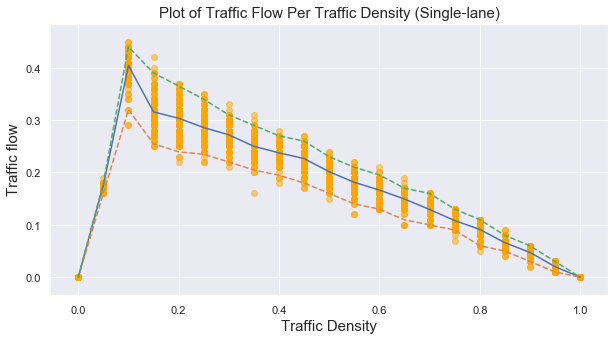

,Traffic Density,Single-lane Mean flow,95 CI
0,0.0,0.0000,"[0.0, 0.0]"
1,0.1,0.4046,"[0.32, 0.44]"
2,0.2,0.3036,"[0.2395, 0.3652499999999999]"
3,0.3,0.2719,"[0.22, 0.31]"
4,0.4,0.2375,"[0.19475, 0.27]"
5,0.5,0.2015,"[0.16, 0.23]"
6,0.6,0.1664,"[0.13, 0.19524999999999992]"
7,0.7,0.1293,"[0.1, 0.16]"
8,0.8,0.0913,"[0.06, 0.11]"
9,0.9,0.0474,"[0.03, 0.06]"


In [25]:
#plot stats
plt.figure(figsize=(10,5))
plot_flow(single_lane_traffic_flows, single_lane_mean, single_lane_CI, 'Single-lane')
plt.show()

#create dataframe
single_lane_df = pd.DataFrame({
    'Traffic Density': density[::2],
    'Single-lane Mean flow': single_lane_mean[::2],
    '95 CI': single_lane_CI[::2]
    })

single_lane_df

In [13]:
print("Maximum Traffic Flow is {} reached at density of {}".format(max(single_lane_mean[::2]), density[single_lane_mean.index(max(single_lane_mean))]))

Maximum Traffic Flow is 0.4011 reached at density of 0.1


<h2>Part 2: Multi-lane Highways</h2>
<h3>Two-lane Traffic Simulation Model</h3>

<h3>Building the Model</h3>

In [14]:
class TrafficSimTwoLane(TrafficSim):

    def __init__(self, length=50, no_of_lanes = 2, car_density=0.3, slow_down_prob=0.5, switch_lane_prob=1, max_speed=5, demo = False):
        
        '''
        TrafficSimTwoLane inherits from the TrafficSim parent class.
        The no_of_lanes is now defaulted at 2.
        A new variable, switch_lane_prob, is introduced.

        Inputs:
        
            no_of_lanes (int) The number of lanes in the simulation. 
                                Default: 2.
                
            switch_lane_prob (int) The probability of a car switching lanes, 
                                   given that a lane switch is possible. 
                                    Default: 1.

        '''
        
        #inherit from parent TrafficSim class
        super().__init__(length, no_of_lanes, car_density, slow_down_prob, max_speed, demo)
        
        #initialize switch_lane_prob
        self.switch_lane_prob = switch_lane_prob
    
    def update_cars(self,old_state,curr_lane,other_lane):
        '''
        Update car velocities with/without lane switch.
        
        For two-lane model, the following steps are implemented:
        
        - acceleration
        - lane-switch
        - random slow down
        
        Inputs:
        
            old_state (arr) A deep copy of the last updated state as reference when
                            updating both lanes
                
            curr_lane (int) The index of the current lane that the car is on.
                                    
            other_lane (int) The index of the other lane that the car can switch to.
        '''
        #loop through the lane
        for i in range(self.length):
            
            #if the index is a car
            if old_state[curr_lane][i] != -1: 
                
                #get front and back distance of current lane
                f_dist, b_dist = self.get_distances(old_state[curr_lane], i)
                
                #get front and back distance of other lane
                fo_dist, bo_dist = self.get_distances(old_state[other_lane], i)
                    
                #Try accelerating in current lane
                if old_state[curr_lane][i] + 1 < f_dist:
                    self.state[curr_lane][i] = min(old_state[curr_lane][i] + 1, self.max_speed)
                
                else: #if acceleration is not possible, try switching lanes:

                    #if switching lanes is possible, switch lane with probability switch_lane_prob.
                    if old_state[other_lane][i] == -1 and old_state[curr_lane][i] + 1 < fo_dist and bo_dist > self.max_speed:
                        
                        if np.random.uniform() < self.switch_lane_prob:
                            
                            #switch to the other lane
                            self.state[other_lane][i] = min(old_state[curr_lane][i] + 1, self.max_speed)
                            #assign empty spot where the car used to be
                            self.state[curr_lane][i] = -1

                    #if switching lanes is not possible, decelerate in current lane
                    else: self.state[curr_lane][i] = max(f_dist - 1, 0)
     

                # Random slow down
                if (self.state[curr_lane][i] > 0) and (np.random.uniform() < self.slow_down_prob): 
                    self.state[curr_lane][i] -= 1

        
    def step(self):
        '''
        Advance one time step in the simulation.
        '''
        #create deep copy of current state for reference when updating both lanes
        old_state = copy.deepcopy(self.state) 
        
        #update car velocities and/or switch lanes
        self.update_cars(old_state,0,1)
        self.update_cars(old_state,1,0)

        #if demo == True, display the traffic sim
        if self.demo: self.display()

        #move cars
        self.state = self.move_cars()

        #Update time and traffic flow
        self.get_traffic_flow()

                

In [15]:
#demo of two-lane traffic simulation
for d in demo_densities:
    sim_demo(f'Two-lane Traffic Model, {d} car density', TrafficSimTwoLane, no_of_lanes = 2, car_density = d)
    
    

Two-lane Traffic Model, 0.03 car density

....................0.......4.....................
...................5..............................

....................1...........5.................
........................5.........................

.....................1...............5............
.............................4....................

......................2...................5.......
.................................4................

........................2......................4..
.....................................5............

.5........................3.......................
..........................................5.......

......5......................3....................
...............................................5..

...........5....................4.................
..5...............................................

................5...................5.............
.......4..........................................

.....................5.........

<h3>Running Simulations</h3>

In [16]:
#generate two-lane traffic flow stats using switch_lane_prob of 0, 0.5, and 1.
two_lane_traffic_flows_0, two_lane_mean_0, two_lane_CI_0 = sim_diff_density(TrafficSimTwoLane, switch_lane_prob=0)
two_lane_traffic_flows_02, two_lane_mean_02, two_lane_CI_02 = sim_diff_density(TrafficSimTwoLane, switch_lane_prob=0.2)
two_lane_traffic_flows_05, two_lane_mean_05, two_lane_CI_05 = sim_diff_density(TrafficSimTwoLane, switch_lane_prob=0.5)
two_lane_traffic_flows_1, two_lane_mean_1, two_lane_CI_1 = sim_diff_density(TrafficSimTwoLane, switch_lane_prob=0.7)


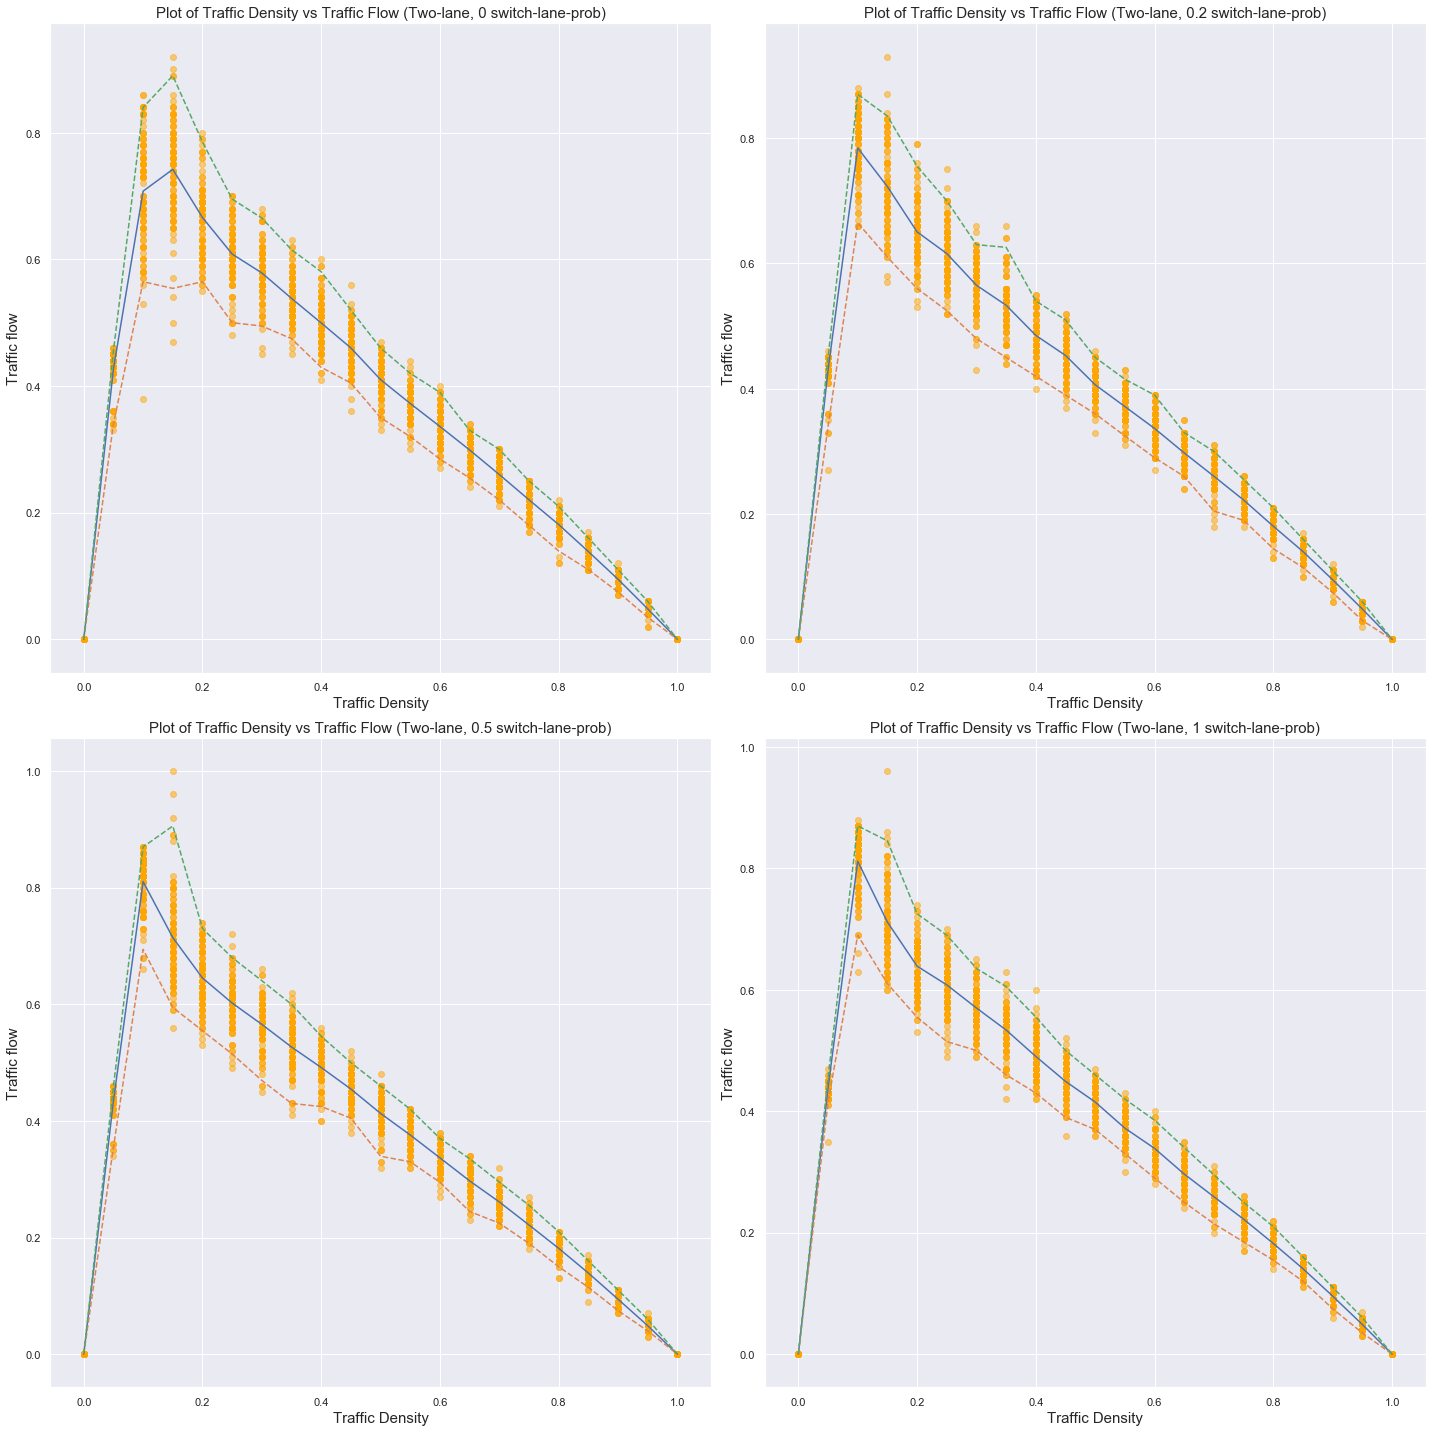

In [22]:
#plot stats
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plot_flow(two_lane_traffic_flows_0, two_lane_mean_0, two_lane_CI_0, f'Two-lane, 0 switch-lane-prob')
plt.subplot(2,2,2)
plot_flow(two_lane_traffic_flows_02, two_lane_mean_02, two_lane_CI_02, f'Two-lane, 0.2 switch-lane-prob')
plt.subplot(2,2,3)
plot_flow(two_lane_traffic_flows_05, two_lane_mean_05, two_lane_CI_05, f'Two-lane, 0.5 switch-lane-prob')
plt.subplot(2,2,4)
plot_flow(two_lane_traffic_flows_1, two_lane_mean_1, two_lane_CI_1, f'Two-lane, 1 switch-lane-prob')
plt.tight_layout()

In [19]:
#create dataframe for two-lane model
two_lane_df = pd.DataFrame({
    'Traffic Density': density[::2],
    'Two-Lane (0 switch_lane_prob) Mean flow': two_lane_mean_0[::2],
    'Two-Lane (0.2 switch_lane_prob) Mean flow': two_lane_mean_02[::2],
    'Two-Lane (0.5 switch_lane_prob) Mean flow': two_lane_mean_05[::2],
    'Two-Lane (1.0 switch_lane_prob) Mean flow': two_lane_mean_1[::2]
    })

#merge single-lane and two-lane dfs together
traffic_flow_df = pd.merge(single_lane_df[['Traffic Density','Single-lane Mean flow']],two_lane_df)

traffic_flow_df

,Traffic Density,Single-lane Mean flow,Two-Lane (0 switch_lane_prob) Mean flow,Two-Lane (0.2 switch_lane_prob) Mean flow,Two-Lane (0.5 switch_lane_prob) Mean flow,Two-Lane (1.0 switch_lane_prob) Mean flow
0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.1,0.4011,0.7078,0.7844,0.8105,0.8118
2,0.2,0.3035,0.6661,0.6504,0.6452,0.6389
3,0.3,0.2744,0.5786,0.5652,0.5656,0.5700
4,0.4,0.2391,0.4996,0.4852,0.4916,0.4902
5,0.5,0.2058,0.4101,0.4064,0.4129,0.4151
6,0.6,0.1670,0.3361,0.3367,0.3367,0.3388
7,0.7,0.1306,0.2602,0.2603,0.2611,0.2591
8,0.8,0.0911,0.1812,0.1806,0.1816,0.1822
9,0.9,0.0493,0.0948,0.0951,0.0943,0.0955


In [45]:
def get_max_vals(df, col_name):

    max_mean_flow = round(df[col_name+' Mean flow'].max(),4)
    max_flow_density = df[df[col_name+' Mean flow']==df[col_name+' Mean flow'].max()]['Traffic Density'][1]

    print(f"{col_name}: Max mean flow is {max_mean_flow} at traffic density {max_flow_density}")

get_max_vals(traffic_flow_df, 'Single-lane')
get_max_vals(traffic_flow_df, 'Two-Lane (0 switch_lane_prob)')
get_max_vals(traffic_flow_df, 'Two-Lane (0.2 switch_lane_prob)')
get_max_vals(traffic_flow_df, 'Two-Lane (0.5 switch_lane_prob)')
get_max_vals(traffic_flow_df, 'Two-Lane (1.0 switch_lane_prob)')


Single-lane: Max mean flow is 0.4011 at traffic density 0.1
Two-Lane (0 switch_lane_prob): Max mean flow is 0.7078 at traffic density 0.1
Two-Lane (0.2 switch_lane_prob): Max mean flow is 0.7844 at traffic density 0.1
Two-Lane (0.5 switch_lane_prob): Max mean flow is 0.8105 at traffic density 0.1
Two-Lane (1.0 switch_lane_prob): Max mean flow is 0.8118 at traffic density 0.1


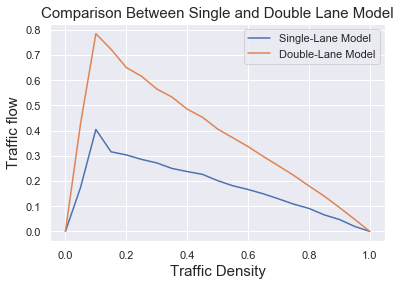

In [38]:
plot_flow_combined(single_lane_mean,two_lane_mean_02)

<h2>Part 3: Extended Single-lane Model</h2>

The extended single-lane model builds on the TrafficSim parent class. Using the extended model, we can investigate the effects of obstacles, speed-limit zones, and traffic lights on regular traffic flow.

<h3>Additional Features of Extended Model:</h3>

- Obstacles
- Speed-limit zones
- Traffic lights


<h3>Building the Model</h3>

In [48]:
#the global time is the number of steps that the model will be updated in the simulation for each simulation loop.
global_time = 100

class TrafficSimExtended(TrafficSim):
    
    def __init__(self, length=100, no_of_lanes = 1, car_density=0.3, slow_down_prob=0.5, 
                 max_speed=5, speed_lim=[5,1,5], 
                 speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]), 
                 traffic_light = (0,50,3,2),
                 obstacle = (0,30),
                 demo = False):
        
        '''
        TrafficSimExtended inherits from the TrafficSim parent class.
        New variables: speed_lim, speed_lim_zone, traffic_light, obstacle.
        
        Inputs:
                
            speed_lim (arr) The speed limits in the speed limit zone ranges.
                Default: [5,1,5]
                
            speed_lim_zone (tuple) The speed limit zone lane and ranges.
                Default: (0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)])
                
            traffic_light (arr) The traffic light lane, index, on-time, and off-time as a tuple.
                Default: (0,50,10,10) traffic light at lane 0, index 50, with 10 on-time and 10 off-time.
                
            obstacle (tuple) The lane and index of the obstacle.
                Default: (0,30) - First lane, index 30.

        '''
        
        #inherit from parent TrafficSim class
        super().__init__(length, no_of_lanes, car_density, slow_down_prob, max_speed, demo)
        
        #speed limit variables
        self.speed_lim = speed_lim
        self.speed_lim_zone = speed_lim_zone
        
        #traffic light variables
        self.traffic_light = traffic_light
        #create regular intervals for go-time and stop-time
        self.traffic_light_int = np.array(
                                    [np.arange(i, i + traffic_light[2]) 
                                    if (i+traffic_light[2])<global_time else np.arange(i,global_time) 
                                    for i in np.arange(global_time)[::(traffic_light[2]+traffic_light[3])]]
                                    ).flatten()
        
        #obstacle variables
        self.obstacle = obstacle
       
    def update_cars(self):

        for i in range(self.length):
            
            #set obstacle index to 0
            if i == self.obstacle[1]: self.state[0][i] = 0
            

            else: #if index is not obstacle, proceed as usual
                
                #if the index is a car
                if self.state[0][i] != -1: 
                    
                    #set current max speed according to traffic light and speed-limit-zone checks
                    curr_max_speed = min(self.check_speed_limit(0,i),self.check_traffic_light(0,i))

                    #get the front and back distances of the current car
                    f_dist, b_dist = self.get_distances(self.state[0],i)

                    #Acceleration
                    if self.state[0][i] + 1 < f_dist:
                        self.state[0][i] = min(self.state[0][i] + 1, curr_max_speed)

                    #Deceleration
                    else: self.state[0][i] = min(max(f_dist - 1, 0), curr_max_speed)
                        
                    #Randomization
                    if (self.state[0][i] > 0) and (np.random.uniform() < self.slow_down_prob):
                        self.state[0][i] -= 1
                    

    def check_speed_limit(self,lane,index):
        '''
        set the current max speed of the car according to speed limit zone restrictions
        '''
        if lane == self.speed_lim_zone[0]:
            for i in range(len(self.speed_lim_zone[1])):
                
                #check which speed limit zone the car is in
                if index in self.speed_lim_zone[1][i]:
                    
                    #assign the appropriate speed limit for that zone
                    return self.speed_lim[i]
                
        return self.max_speed
    
    def check_traffic_light(self,lane,index):
        '''
        Checks if:
        - traffic light is on,
        - car is on traffic light lane, and
        - car's current velocity + index >= traffic light index
        if all conditions are met, the car's max velocity is (traffic_light_index - car_index).
        
        Traffic light turns on at the first time-step, then turns off and on in regular intervals
        as specified in self.traffic_light_int
        '''
        #if traffic light is on
        if self.time_step in self.traffic_light_int:
            
            #if the current lane is the traffic light lane
            if lane == self.traffic_light[0]:
                
                #if the car is behind or at the traffic light
                if index <= self.traffic_light[1]:
                
                    #if the car's next step >= the traffic light index
                    if self.state[lane][index] + index >= self.traffic_light[1]:
                        return self.traffic_light[1] - index
                
        #if none of the above conditions are met, return regular max velocity
        return self.max_speed
        
    def display(self):
        '''
        Traffic light index is red when off, green when on.
        Obstacle index is blue.
        '''
        for lane in range(self.no_of_lanes):
            
            disp = ['.' if x == -1 else str(x) for x in self.state[lane]]
            
            #print obstacle blue
            if lane == self.obstacle[0]:
                disp[self.obstacle[1]] = f"\x1b[34m{disp[self.obstacle[1]]}\x1b[0m"
            
            #print traffic light red when it's on, green when it's off
            if lane == self.traffic_light[0]:
                if self.time_step in self.traffic_light_int:
                    disp[self.traffic_light[1]] = f"\x1b[31m{disp[self.traffic_light[1]]}\x1b[0m"
                else:
                    disp[self.traffic_light[1]] = f"\x1b[32m{disp[self.traffic_light[1]]}\x1b[0m"
            
            print(''.join(x for x in disp))
            
        print()
            


In [49]:
#demo of extended single-lane traffic simulation
#obstacle at index 30
#traffic light at index 50, on-time of 3, off-time of 2.
#speed limit of 1 in the range (34,67)

np.random.seed(34)
for d in demo_densities:
    sim_demo(f'Single-lane Extended Traffic Model, {d} car density', TrafficSimExtended, car_density = d)
    

Single-lane Extended Traffic Model, 0.03 car density

..............01..............0...........................................2.........................

..............0.2.............0.............................................3.......................

..............1...2...........0................................................4....................

...............1....3.........0....................................................4................

................1......4......0........................................................5............

.................2.........2..0.............................................................5.......

...................2.........00..................................................................4..

.5...................3.......00.....................................................................

......4.................4....00.....................................................................

..........5.................

<h2>Part 4: Extended Two-lane Model</h2>

The extended two-lane model builds on the TrafficSimTwoLane parent class. Using the extended model, we can investigate the effects of obstacles, speed-limit zones, traffic lights, and lane-merges on regular traffic flow.

<h3>Additional Features of Extended Two-Lane Model:</h3>

The additional features are similar to the extended single-lane model, with the addition of a lane-merge feature:

- Lane merges (only for two-lane model)
    - Permanent 0-valued chain of stationary objects set along a series of cells on the road.


<h3>Building the Model</h3>

In [15]:
class TrafficSimExtendedTwoLane(TrafficSimExtended):
    
    def __init__(self, length=100, no_of_lanes = 2, car_density=0.3, 
                 slow_down_prob=0.5, switch_lane_prob = 1,
                 max_speed=5, speed_lim=[5,1,5], 
                 speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]), 
                 traffic_light = (0,50,3,2),
                 obstacle = (0,30),
                 lane_merge = (0,np.arange(70,100)),
                 demo = False):
        
        '''
        TrafficSimExtendedTwoLane inherits from the TrafficSimExtended parent class.
        The no_of_lanes is now defaulted at 2.
        New variables: switch_lane_prob, lane_merge.

        Inputs:
        
            no_of_lanes (int) The number of lanes in the simulation. 
                Default: 2.
                
            switch_lane_prob (int) The probability of a car switching lanes, 
                                    given that a lane switch is possible. 
                Default: 1.
                
            lane_merge (tuple) The lane and indices where lane-merge occurs.
                Default: (0, np.arange(75,100))

        '''
        
        #inherit from TrafficSimExtended class
        super().__init__(length, no_of_lanes, car_density, slow_down_prob, 
                         max_speed, speed_lim, speed_lim_zone, 
                         traffic_light, obstacle, demo)
        
        #initialize new variable, switch-lane_prob
        self.switch_lane_prob = switch_lane_prob
        
        #lane-merge variable
        self.lane_merge = lane_merge
       
    def update_cars(self,old_state,curr_lane,other_lane):

        for i in range(self.length):
            
            #obstacle check
            if curr_lane == self.obstacle[0] and i == self.obstacle[1]:
                old_state[curr_lane][i] = 0
                self.state[curr_lane][i] = 0
                
            #lane-merge check
            elif curr_lane == self.lane_merge[0] and i in self.lane_merge[1]:
                old_state[curr_lane][i] = 0
                self.state[curr_lane][i] = 0
            
            else: #if not obstacle, proceed as usual
                
                #if the index is a car
                if old_state[curr_lane][i] != -1: 

                    #set current max speed according to traffic light and speed-limit-zone checks
                    curr_max_speed = min(self.check_speed_limit(curr_lane,i),self.check_traffic_light(curr_lane,i))

                    #get front and back distance of current lane
                    f_dist, b_dist = self.get_distances(old_state[curr_lane], i)

                    #get front and back distance of other lane
                    fo_dist, bo_dist = self.get_distances(old_state[other_lane], i)

                    #Acceleration in current lane
                    if old_state[curr_lane][i] + 1 < f_dist:
                        self.state[curr_lane][i] = min(old_state[curr_lane][i] + 1, curr_max_speed)

                    else: #if acceleration is not possible, try switching lanes
                        
                        #check if there is no car occupying the other lane at the same index, and that there is sufficient front and back distance
                        if old_state[other_lane][i] == -1 and old_state[curr_lane][i] + 1 < fo_dist and bo_dist > self.max_speed:

                            #check what the max speed in the other lane would be based on speed limits and traffic lights
                            other_max_speed = min(self.check_speed_limit(other_lane,i),self.check_traffic_light(other_lane,i))
                            
                            #if the car can travel faster in the other lane
                            if other_max_speed > curr_max_speed and np.random.uniform() < self.switch_lane_prob:
                                
                                #switch to the other lane
                                self.state[other_lane][i] = min(old_state[curr_lane][i] + 1, other_max_speed)
                                #assign empty spot where the car used to be
                                self.state[curr_lane][i] = -1
        
                        #if switching lanes is not possible or not worth it, decelerate in current lane
                        else: self.state[curr_lane][i] = min(max(f_dist - 1, 0), curr_max_speed)

                    # Random slow down
                    if (self.state[curr_lane][i] > 0) and (np.random.uniform() < self.slow_down_prob): 
                        self.state[curr_lane][i] -= 1
   
        
    def step(self):
        '''
        Advance one time step in the simulation.
        '''
        #create deep copy of current state for reference when updating both lanes
        old_state = copy.deepcopy(self.state) 
        
        #update car velocities / switch lanes and update velocities
        self.update_cars(old_state,0,1)
        self.update_cars(old_state,1,0)

        #if demo == True, display the traffic sim
        if self.demo: self.display()

        #move cars
        self.state = self.move_cars()

        #Update time and traffic flow
        self.get_traffic_flow()
        
    def display(self):
        '''
        Traffic light index is red when off, green when on.
        Obstacle is blue.
        Lane merge is represented as '_'
        '''
        for lane in range(self.no_of_lanes):
            
            disp = ['.' if x == -1 else str(x) for x in self.state[lane]]
            
            #print obstacle blue
            if lane == self.obstacle[0]:
                disp[self.obstacle[1]] = f"\x1b[34m{disp[self.obstacle[1]]}\x1b[0m"
                
            #print lane merge as '_'
            if lane == self.lane_merge[0]:
                for i in range(len(self.lane_merge[1])):
                    disp[self.lane_merge[1][i]] = '_'
            
            #print traffic light red when it's on, green when it's off
            if lane == self.traffic_light[0]:
                if self.time_step in self.traffic_light_int:
                    disp[self.traffic_light[1]] = f"\x1b[31m{disp[self.traffic_light[0]]}\x1b[0m"
                else:
                    disp[self.traffic_light[1]] = f"\x1b[32m{disp[self.traffic_light[0]]}\x1b[0m"
            
            print(''.join(x for x in disp))
            
        print()

        

In [16]:
#demo of extended two-lane traffic simulation
#obstacle at index 30
#lane-merge in the range(70,100)
#traffic light at index 50, on-time of 3, off-time of 2.
#speed limit of 1 in the range (34,67)

np.random.seed(123)

for d in demo_densities:
    sim_demo(f'Two-lane Extended Traffic Model, {d} car density', TrafficSimExtendedTwoLane, car_density = d, slow_down_prob=0)
    

Two-lane Extended Traffic Model, 0.1 car density

....5..............04.........01.....1...............1................______________________________
....3...3............2.....4.....................4........2...5...............02..2..3...5..........

.........5.........1....5.....0.2.....1...............1...............______________________________
.......3...4...........3.......5.....................5......3......5..........1..2..3...4.....5.....

..............5.....2........00...1....1...............1..............______________________________
..........4....5..........4.........5.....................4....4........5......2...3...4....5......5

...................2..3......00....1....1...............1.............______________________________
....5.........5.....5.........5..........5....................4....5.........3...3....4....5.....5..

.....................3...3...00.....1....1.........1.....1............______________________________
..5......5.........5.....5.........5.

<h3>Running Simulations for Extended Models</h3>

Before running any simulations, we can intuitively predict that the extended single-lane model will always have a poorer performance vs the extended two-lane model when there are speed limit zones, obstacles, or traffic lights. This is because in the two-lane model, if there is an obstacle, speed limit zone, or red traffic light on the current lane, if the car can travel faster in the other lane and it is safe to switch lanes, the car can switch lanes. However, in the single-lane model, cars will always be stuck in the same lane. If there is a speed limit, they have to adhere; if there is an obstacle, they will start forming a build-up, if there is a red traffic-light, they will have to stop. 

Simulations will be carried out to confirm this intuition.

The simulations will compare:

- speed-limit zone in single-lane model vs two-lane model.


       - speed-limit of [ 5, 1, 5 ] in ranges ( 0, 34 ), ( 34, 67 ), ( 67, 100 ) respectively.
    

- traffic light in single-lane model vs two-lane model.


     - traffic light in lane 0, index 50.
     
     - traffic light intervals of 10 on, 10 off.

- obstacle in single-lane model vs lane-merge in two-lane model.


    - obstacle in lane 0, index 70 for single-lane model.
    
    - lane-merge in lane 0, in range ( 70, 100 ) for two-lane model.



All the added features will have the same settings, e.g. same lane, same index, same time-intervals (for traffic light). For example, if the obstacle was located on lane 0, index 30 in the single-lane model, it will also be located on lane 0, index 30 in the two-lane model.

In [17]:
#speed-limit zones

speed_lim_1_traffic_flows, speed_lim_1_mean, speed_lim_1_CI = sim_diff_density(TrafficSimExtended,
                                                                                traffic_light = (-1,-1,3,2),
                                                                                obstacle = (-1,30),
                                                                                speed_lim=[5,1,5], 
                                                                                speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]))
speed_lim_2_traffic_flows, speed_lim_2_mean, speed_lim_2_CI = sim_diff_density(TrafficSimExtendedTwoLane,
                                                                                traffic_light = (-1,-1,3,2),
                                                                                obstacle = (-1,30),
                                                                                speed_lim=[5,1,5], 
                                                                                speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]),
                                                                                lane_merge = (-1,np.arange(-1,-100)))



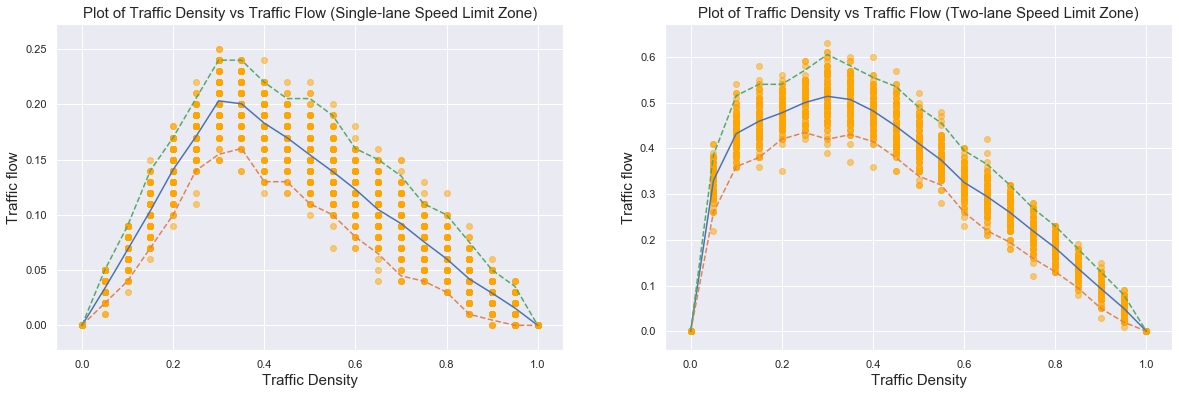

,Traffic Density,Single-lane Mean flow,Two-lane Mean flow
0,0.0,0.0000,0.0000
1,0.1,0.0684,0.4322
2,0.2,0.1409,0.4777
3,0.3,0.2032,0.5138
4,0.4,0.1830,0.4821
5,0.5,0.1543,0.4108
6,0.6,0.1231,0.3255
7,0.7,0.0921,0.2601
8,0.8,0.0602,0.1824
9,0.9,0.0291,0.0933


In [18]:
#plot stats
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plot_flow(speed_lim_1_traffic_flows, speed_lim_1_mean, speed_lim_1_CI, 'Single-lane Speed Limit Zone')
plt.subplot(1,2,2)
plot_flow(speed_lim_2_traffic_flows, speed_lim_2_mean, speed_lim_2_CI, 'Two-lane Speed Limit Zone')
plt.show()

#create dataframe
speed_lim_df = pd.DataFrame({
    'Traffic Density': density[::2],
    'Single-lane Mean flow': speed_lim_1_mean[::2],
    'Two-lane Mean flow': speed_lim_2_mean[::2]
    })

speed_lim_df


In [19]:
#traffic lights

tl_1_traffic_flows, tl_1_mean, tl_1_CI = sim_diff_density(TrafficSimExtended,
                                                        traffic_light = (0,50,10,10),
                                                        obstacle = (-1,30),
                                                        speed_lim=[5,5,5], 
                                                        speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]))
tl_2_traffic_flows, tl_2_mean, tl_2_CI = sim_diff_density(TrafficSimExtendedTwoLane,
                                                        traffic_light = (0,50,10,10),
                                                        obstacle = (-1,30),
                                                        speed_lim=[5,5,5], 
                                                        speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]),
                                                        lane_merge = (-1,np.arange(-1,-100)))



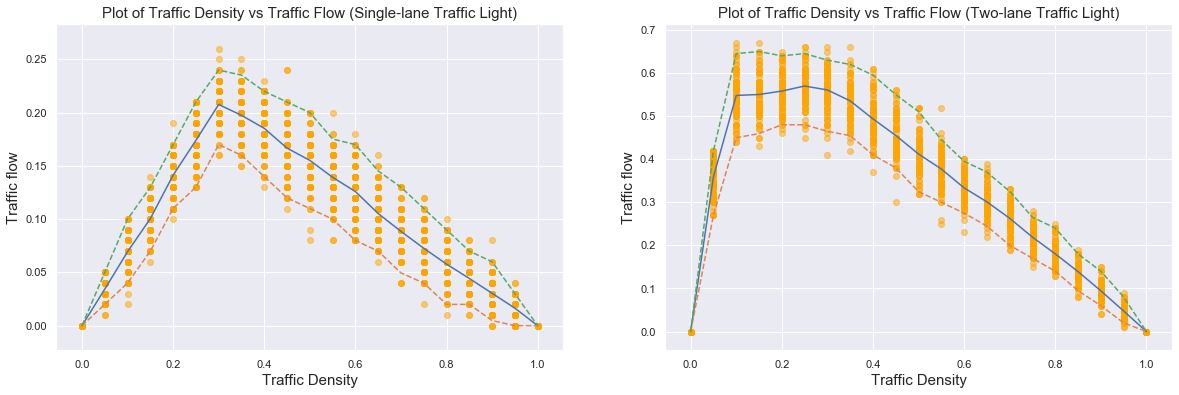

,Traffic Density,Single-lane Mean flow,Two-lane Mean flow
0,0.0,0.0000,0.0000
1,0.1,0.0694,0.5481
2,0.2,0.1413,0.5582
3,0.3,0.2077,0.5608
4,0.4,0.1853,0.4936
5,0.5,0.1552,0.4120
6,0.6,0.1259,0.3334
7,0.7,0.0885,0.2628
8,0.8,0.0578,0.1802
9,0.9,0.0304,0.0944


In [20]:
#plot stats
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plot_flow(tl_1_traffic_flows, tl_1_mean, tl_1_CI, 'Single-lane Traffic Light')
plt.subplot(1,2,2)
plot_flow(tl_2_traffic_flows, tl_2_mean, tl_2_CI, 'Two-lane Traffic Light')
plt.show()

#create dataframe
tl_df = pd.DataFrame({
    'Traffic Density': density[::2],
    'Single-lane Mean flow': tl_1_mean[::2],
    'Two-lane Mean flow': tl_2_mean[::2]
    })

tl_df

In [21]:
#obstacle & lane-merge

obs_1_traffic_flows, obs_1_mean, obs_1_CI = sim_diff_density(TrafficSimExtended,
                                                        traffic_light = (-1,-1,10,10),
                                                        obstacle = (0,70),
                                                        speed_lim=[5,5,5], 
                                                        speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]))
obs_2_traffic_flows, obs_2_mean, obs_2_CI = sim_diff_density(TrafficSimExtendedTwoLane,
                                                        traffic_light = (-1,-1,10,10),
                                                        obstacle = (0,70),
                                                        speed_lim=[5,5,5], 
                                                        speed_lim_zone=(0,[np.arange(0,34),np.arange(34,67),np.arange(67,100)]),
                                                        lane_merge = (0,np.arange(70,100)))



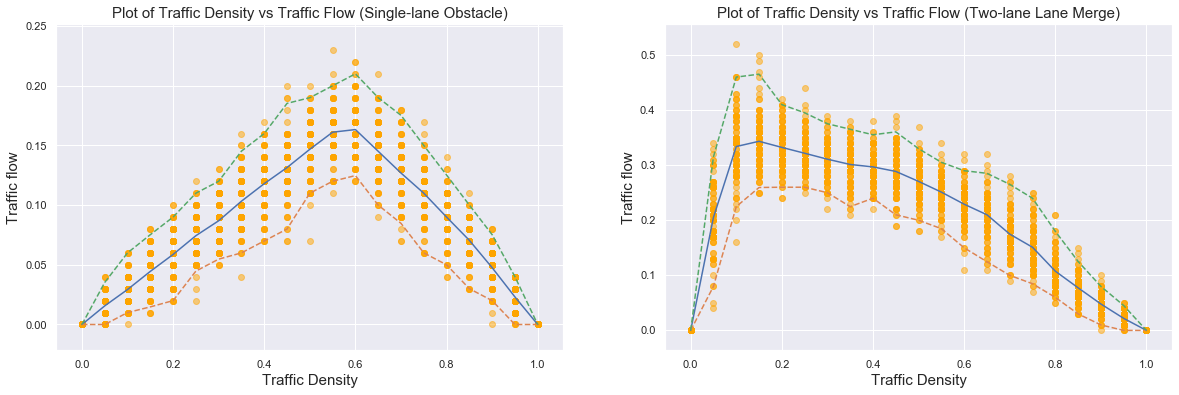

,Traffic Density,Single-lane Mean flow,Two-lane Mean flow
0,0.0,0.0000,0.0000
1,0.1,0.0293,0.3339
2,0.2,0.0587,0.3323
3,0.3,0.0869,0.3109
4,0.4,0.1180,0.2969
5,0.5,0.1468,0.2706
6,0.6,0.1633,0.2292
7,0.7,0.1269,0.1749
8,0.8,0.0900,0.1076
9,0.9,0.0476,0.0480


In [22]:
#plot stats
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plot_flow(obs_1_traffic_flows, obs_1_mean, obs_1_CI, 'Single-lane Obstacle')
plt.subplot(1,2,2)
plot_flow(obs_2_traffic_flows, obs_2_mean, obs_2_CI, 'Two-lane Lane Merge')
plt.show()

#create dataframe
obs_df = pd.DataFrame({
    'Traffic Density': density[::2],
    'Single-lane Mean flow': obs_1_mean[::2],
    'Two-lane Mean flow': obs_2_mean[::2]
    })

obs_df